In [1]:
import matplotlib.pyplot as plt
import src.libs.ikrlib as il
import numpy as np
from numpy.random import randint
import scipy

In [2]:
# load all files from directories
target_dev = list(il.wav16khz2mfcc('data/target_dev/').values())
target_train = list(il.wav16khz2mfcc('data/target_train/').values())
non_target_dev = list(il.wav16khz2mfcc('data/non_target_dev/').values())
non_target_train = list(il.wav16khz2mfcc('data/non_target_train/').values())

Processing file:  data/target_dev/m430_03_p01_i0_0.wav
Processing file:  data/target_dev/m430_03_p02_i0_0.wav
Processing file:  data/target_dev/m430_03_p03_i0_0.wav
Processing file:  data/target_dev/m430_03_p04_i0_0.wav
Processing file:  data/target_dev/m430_03_p05_i0_0.wav
Processing file:  data/target_dev/m430_03_r06_i0_0.wav
Processing file:  data/target_dev/m430_03_r07_i0_0.wav
Processing file:  data/target_dev/m430_03_r08_i0_0.wav
Processing file:  data/target_dev/m430_03_r09_i0_0.wav
Processing file:  data/target_dev/m430_03_r10_i0_0.wav
Processing file:  data/target_train/m430_01_p01_i0_0.wav
Processing file:  data/target_train/m430_01_p02_i0_0.wav
Processing file:  data/target_train/m430_01_p03_i0_0.wav
Processing file:  data/target_train/m430_01_p04_i0_0.wav
Processing file:  data/target_train/m430_01_p05_i0_0.wav
Processing file:  data/target_train/m430_01_r06_i0_0.wav
Processing file:  data/target_train/m430_01_r07_i0_0.wav
Processing file:  data/target_train/m430_01_r08_i0_

In [4]:
target_train = np.vstack(target_train)
non_target_train = np.vstack(non_target_train)

dim = target_train.shape[1]
dim2 = non_target_train.shape[1]
print(target_train.shape)
print(dim2)

(27252, 13)
13


PCA (mainly overtaken from SUR example project *demo_genderID.py*)
===

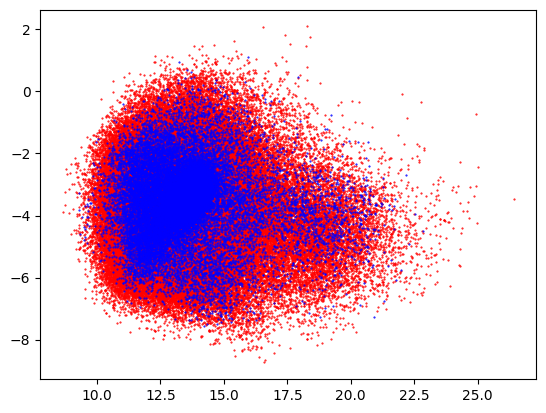

In [5]:
# PCA analysis
cov_tot = np.cov(np.vstack([target_train, non_target_train]).T, bias=True)
# division was obtained when used 5 last vectors, but still it is bad
d, e = scipy.linalg.eigh(cov_tot, subset_by_index=[dim-3, dim-1]) 

target_train_pca = target_train.dot(e)
non_target_train_pca = non_target_train.dot(e)
plt.plot(non_target_train_pca[:,1], non_target_train_pca[:,0], 'r.', ms=1)
plt.plot(target_train_pca[:,1], target_train_pca[:,0], 'b.', ms=1)
plt.show()

LDA (mainly overtaken from SUR example project *demo_genderID.py*)
===

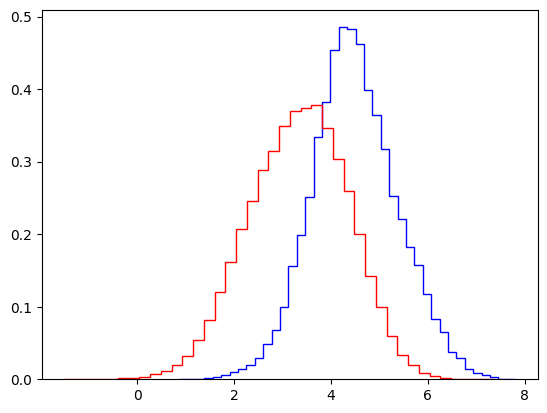

In [6]:
# LDA analysis
n_target = len(target_train)
n_non_target = len(non_target_train)
cov_wc = (n_target*np.cov(target_train.T, bias=True) + n_non_target*np.cov(non_target_train.T, bias=True)) / (n_target + n_non_target)
cov_ac = cov_tot - cov_wc
d, e = scipy.linalg.eigh(cov_ac, cov_wc, eigvals=(dim-1, dim-1))
plt.figure()
junk = plt.hist(target_train.dot(e), 40, histtype='step', color='b',density=True)
junk = plt.hist(non_target_train.dot(e), 40, histtype='step', color='r',density=True)
plt.show()

In [24]:
# do tests on LDA
# Lets define uniform a-priori probabilities of classes:
P_target = 20 / 152# 0.5
P_non_target = 1 - P_target   
print(np.log(P_target))
test_set=target_dev

score=[]
mean_target, cov_target = il.train_gauss(target_train)
mean_non_target, cov_non_target = il.train_gauss(non_target_train)
for tst in test_set:
    ll_target = il.logpdf_gauss(tst, mean_target, cov_target)
    ll_non_target = il.logpdf_gauss(tst, mean_non_target, cov_non_target)
    score_sum = (sum(ll_target) + np.log(P_target)) - (sum(ll_non_target) + np.log(P_non_target))
    score.append(score_sum > 0 if test_set==target_dev else score_sum < 0)
print(sum(score) / len(score))

# Run recognition with 1-dimensional LDA projected data
score=[]
mean_target, cov_target = il.train_gauss(target_train.dot(e))
mean_non_target, cov_non_target = il.train_gauss(non_target_train.dot(e))
for tst in test_set:
    ll_target = il.logpdf_gauss(tst.dot(e), mean_target, np.atleast_2d(cov_target))
    ll_non_target = il.logpdf_gauss(tst.dot(e), mean_non_target, np.atleast_2d(cov_non_target))
    score_sum = (sum(ll_target) + np.log(P_target)) - (sum(ll_non_target) + np.log(P_non_target))
    score.append(score_sum > 0 if test_set==target_dev else score_sum < 0)
print(sum(score) / len(score))


# the only gaussian and LDA models are same considering their success rate

-2.028148247292285
1.0
1.0


GMM (mainly overtaken from SUR example project *demo_genderID.py*)
===

In [7]:
P_target = 20 / 152
P_non_target = 1 - P_target  

# Decide for number of gaussian mixture components used for the target data
num_comp_target = 3
MUs_target  = target_train[randint(1, len(target_train), num_comp_target)]
COVs_target = [np.var(target_train, axis=0)] * num_comp_target
Ws_target = np.ones(num_comp_target) / num_comp_target;


# Initialize parameters of non target data
num_comp_non_target = 4
MUs_non_target  = non_target_train[randint(1, len(non_target_train), num_comp_non_target)]
COVs_non_target = [np.var(non_target_train, axis=0)] * num_comp_non_target
Ws_non_target   = np.ones(num_comp_non_target) / num_comp_non_target;

# Run 30 iterations of EM algorithm to train the two GMMs from target and non target data
for jj in range(50):
  [Ws_target, MUs_target, COVs_target, TTL_target] = il.train_gmm(target_train, Ws_target, MUs_target, COVs_target); 
  [Ws_non_target, MUs_non_target, COVs_non_target, TTL_non_target] = il.train_gmm(non_target_train, Ws_non_target, MUs_non_target, COVs_non_target); 
  print('Iteration:', jj, ' Total log-likelihood:', TTL_target, 'for target;', TTL_non_target, 'for non target')

# perform testing
score=[]
for tst in target_dev:
    ll_target = il.logpdf_gmm(tst, Ws_target, MUs_target, COVs_target)
    ll_non_target = il.logpdf_gmm(tst, Ws_non_target, MUs_non_target, COVs_non_target)
    score.append((sum(ll_target) + np.log(P_target)) - (sum(ll_non_target) + np.log(P_non_target)))
print(score)

score=[]
for tst in non_target_dev:
    ll_target = il.logpdf_gmm(tst, Ws_target, MUs_target, COVs_target)
    ll_non_target = il.logpdf_gmm(tst, Ws_non_target, MUs_non_target, COVs_non_target)
    score.append((sum(ll_target) + np.log(P_target)) - (sum(ll_non_target) + np.log(P_non_target)))
print(score)

Iteration: 0  Total log-likelihood: -408056.38357593113 for target; -3197637.549417244 for non target
Iteration: 1  Total log-likelihood: -337366.70007057616 for target; -2391800.6170522976 for non target
Iteration: 2  Total log-likelihood: -324321.3376882318 for target; -2306593.7810865333 for non target
Iteration: 3  Total log-likelihood: -310735.6224981714 for target; -2270630.89594052 for non target
Iteration: 4  Total log-likelihood: -300906.44272307603 for target; -2249204.790838389 for non target
Iteration: 5  Total log-likelihood: -292395.471879006 for target; -2235310.043082784 for non target
Iteration: 6  Total log-likelihood: -288431.0083235599 for target; -2224506.5941265314 for non target
Iteration: 7  Total log-likelihood: -287354.72836801445 for target; -2217090.198071018 for non target
Iteration: 8  Total log-likelihood: -286822.5933074147 for target; -2212304.2274905164 for non target
Iteration: 9  Total log-likelihood: -286518.9477414363 for target; -2209186.740084567

NEURAL NETWORK
===

In [8]:
# build simple neural network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from glob import glob

In [9]:
# load spectograms of files, also all wav files are shortened for the first 1.5s
max_length = 0
max_freq = 0

start_idx_of_signal = int(16000*1.5)
target_dev = []
for f in glob('data/target_dev/' + '/*.wav'):
    fs,s = il.wavfile.read(f)
    s = s[start_idx_of_signal:]
    f,t,sg = scipy.signal.spectrogram(s,fs)
    max_length = len(t) if len(t) > max_length else max_length
    max_freq = len(f) if len(f) > max_freq else max_freq
    target_dev.append(sg)

target_train = []
for f in glob('data/target_train/' + '/*.wav'):
    fs,s = il.wavfile.read(f)
    s = s[start_idx_of_signal:]
    _,t,sg = scipy.signal.spectrogram(s,fs)
    max_length = len(t) if len(t) > max_length else max_length
    max_freq = len(f) if len(f) > max_freq else max_freq
    target_train.append(sg)

non_target_dev = []
for f in glob('data/non_target_dev/' + '/*.wav'):
    fs,s = il.wavfile.read(f)
    s = s[start_idx_of_signal:]
    _,t,sg = scipy.signal.spectrogram(s,fs)
    max_length = len(t) if len(t) > max_length else max_length
    max_freq = len(f) if len(f) > max_freq else max_freq
    non_target_dev.append(sg)
    
non_target_train = []
for f in glob('data/non_target_train/' + '/*.wav'):
    fs,s = il.wavfile.read(f)
    s = s[start_idx_of_signal:]
    _,t,sg = scipy.signal.spectrogram(s,fs)
    max_length = len(t) if len(t) > max_length else max_length
    max_freq = len(f) if len(f) > max_freq else max_freq
    non_target_train.append(sg)
    

In [10]:
# pad spectograms for each train data (and combine them together)
padded_spectrograms = []
for data in [target_train,non_target_train]:
    for spec in data:
        padded_spec = np.pad(spec, ((0, 0), (0, max_length - spec.shape[1])), mode='constant')
        padded_spectrograms.append(padded_spec)

# convert padded train data to 
padded_spectrograms = np.array(padded_spectrograms)

In [11]:
# compute standard deviation and mean for potentional normalization of spectrograms
spec_mean = np.mean(padded_spectrograms)
spec_std = np.std(padded_spectrograms)
# normalized_train_data = (padded_spectrograms - spec_mean) / spec_std
print(f"Spectogram mean is {spec_mean} and standard deviation is {spec_std}")

Spectogram mean is 12.048662185668945 and standard deviation is 687.1669311523438


In [159]:
max_freq, max_length

(129, 3517)

In [12]:
# create labels (we know that target and non target data goes one by one as we loaded them two cells before)
labels_target = np.linspace(0,0,len(target_train))
labels_non_target = np.linspace(1,1,len(non_target_train))
labels_for_train = np.concatenate((labels_target,labels_non_target),axis=None)

In [13]:
# prepare data as input for neural network
spectrograms_tensor = torch.Tensor(padded_spectrograms) 

labels_tensor = torch.LongTensor(labels_for_train) 

dataset = TensorDataset(spectrograms_tensor.unsqueeze(1), labels_tensor)

In [14]:
# build the model
class CNN(nn.Module):
    def __init__(self,height,width,num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * (height // 4) * (width // 4), 128)
        self.fc2 = nn.Linear(128, num_classes)  # num_classes is the number of output classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)  # Flatten feature maps
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

_, height, width = padded_spectrograms.shape

# Initialize the CNN model
model = CNN(height,width,2)

In [15]:
# check the padded spectrogram shape
padded_spectrograms.shape

(152, 129, 3517)

In [233]:
# define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor([132/152,20/152]))
optimizer = optim.Adam(model.parameters(), lr=0.001)

# create DataLoader for batch processing
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# training
num_epochs = 10
for epoch in range(num_epochs):
    for batch_inputs, batch_labels in dataloader:
        # forward
        outputs = model(batch_inputs)
        
        # loss
        loss = criterion(outputs, batch_labels)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/10, Loss: 104.03392028808594
Epoch 2/10, Loss: 72.42066192626953
Epoch 3/10, Loss: 5.832569122314453
Epoch 4/10, Loss: 281.0644226074219
Epoch 5/10, Loss: 0.0
Epoch 6/10, Loss: 0.0
Epoch 7/10, Loss: 5.825839996337891
Epoch 8/10, Loss: 1.015988271291235e-08
Epoch 9/10, Loss: 0.0
Epoch 10/10, Loss: 0.0


In [235]:
# testing
# pad spectograms for each test data
ps_target_dev = []
for spec in target_dev:
        padded_spec = np.pad(spec, ((0, 0), (0, max_length - spec.shape[1])), mode='constant')
        ps_target_dev.append(padded_spec)

ps_non_target_dev = []
for spec in non_target_dev:
        padded_spec = np.pad(spec, ((0, 0), (0, max_length - spec.shape[1])), mode='constant')
        ps_non_target_dev.append(padded_spec)

# convert padded train data to 
ps_target_dev = np.array(ps_target_dev)
ps_non_target_dev = np.array(ps_non_target_dev)

# target dev spectrograms tensor
td_tensor = torch.Tensor(ps_target_dev)
sum_pred_td = 0
for t in td_tensor:
    input_spec = t.unsqueeze(0).unsqueeze(0)
    pred_class = torch.argmax(model(input_spec))
    sum_pred_td += pred_class.int()
print(f"Success rate on target_dev: {1-sum_pred_td/len(td_tensor)}")

# target dev spectrograms tensor
non_td_tensor = torch.Tensor(ps_non_target_dev)
sum_pred_td = 0
for t in non_td_tensor:
    input_spec = t.unsqueeze(0).unsqueeze(0)
    pred_class = torch.argmax(model(input_spec))
    sum_pred_td += pred_class.int()
print(f"Success rate on non_target_dev: {sum_pred_td/len(non_td_tensor)}")

Success rate on target_dev: 0.8999999761581421
Success rate on non_target_dev: 0.9833333492279053
